# Image Preprocessing 

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-05-13 22:44:01.300299: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 22:44:01.300448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 22:44:01.426409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device:', tf.test.gpu_device_name())
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Histogram Image Enhancement 

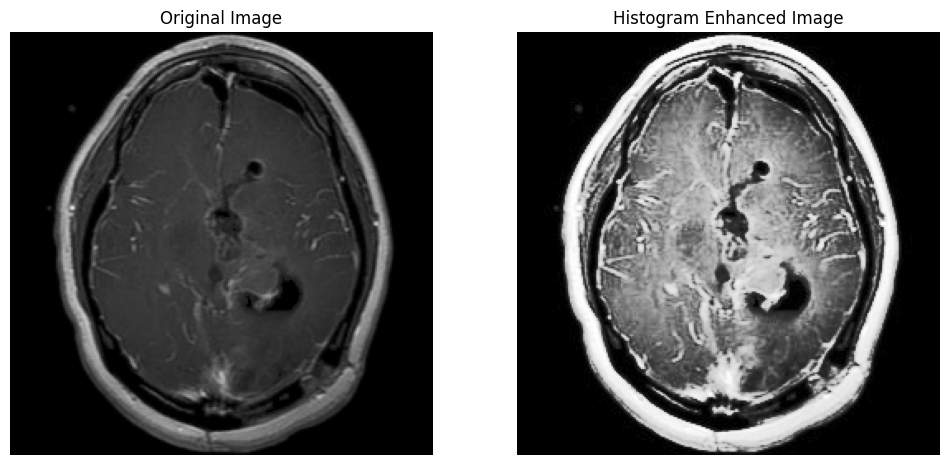

In [3]:
def apply_histogram_equalization(image):
    if len(image.shape) == 2:  # Grayscale image
        return cv2.equalizeHist(image)
    elif len(image.shape) == 3:  # Color image
        # Convert to YUV color space
        yuv_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        # Equalize the histogram of the Y channel
        yuv_img[:, :, 0] = cv2.equalizeHist(yuv_img[:, :, 0])
        # Convert back to RGB color space
        result_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)
        return result_img

# Path to the directory containing image files
directory_path = '/kaggle/input/brain-tumors-256x256/Data/glioma_tumor'

# List all files in the directory
image_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

# Choose one image randomly for detailed comparison
chosen_image = image_files[0]

# Load the chosen image
chosen_image_path = os.path.join(directory_path, chosen_image)
chosen_image_data = cv2.imread(chosen_image_path, cv2.IMREAD_COLOR)

if chosen_image_data is None:
    print("Error: Image could not be read. Make sure the path is correct.")
else:
    # Convert color from BGR to RGB
    chosen_image_data_rgb = cv2.cvtColor(chosen_image_data, cv2.COLOR_BGR2RGB)

    # Apply histogram equalization
    chosen_enhanced_image = apply_histogram_equalization(chosen_image_data_rgb)

    # Plotting original and enhanced images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(chosen_image_data_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(chosen_enhanced_image)
    plt.title('Histogram Enhanced Image')
    plt.axis('off')

    plt.show()

### applying the enhancement on the dataset

In [4]:
input_directory = '/kaggle/input/brain-tumors-256x256/Data/glioma_tumor'

# Path to the directory where enhanced images will be saved
output_directory = 'Data/glioma_tumor_histo'
os.makedirs(output_directory, exist_ok=True)

# List all files in the input directory
image_files = [f for f in os.listdir(input_directory) if os.path.isfile(os.path.join(input_directory, f))]

# Process each image
for filename in image_files:
    # Load the image
    image_path = os.path.join(input_directory, filename)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if image is not None:
        # Apply histogram equalization
        enhanced_image = apply_histogram_equalization(image)

        # Save the enhanced image to the output directory
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, enhanced_image)

print("Enhanced images saved to:", output_directory)

Enhanced images saved to: Data/glioma_tumor_histo


## Contrast Stretching 
Used for normalizing the brightness levels 

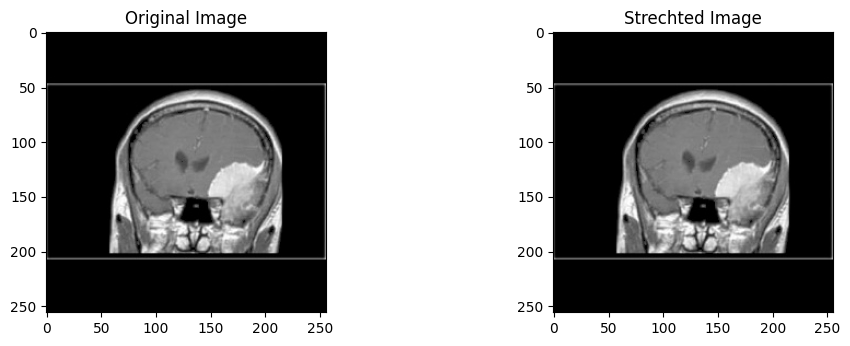

In [5]:
def contrast_stretching(img):
    # Convert to float to avoid overflow issues during calculation
    img_float = img.astype(float)
    
    # Compute the min and max pixel values
    a = np.min(img_float)
    b = np.max(img_float)
    
    # Perform contrast stretching
    stretched_img = 255 * ((img_float - a) / (b - a))
    stretched_img = stretched_img.astype(np.uint8)
    
    return stretched_img

# Load an image in grayscale
image = cv2.imread('/kaggle/input/brain-tumors-256x256/Data/meningioma_tumor/M_1.jpg', 0)

# Apply contrast stretching
stretched_image = contrast_stretching(image)

# Display the original and stretched images
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Strechted Image')
plt.imshow(stretched_image, cmap='gray')

plt.show()

In [6]:
input_directory = '/kaggle/input/brain-tumors-256x256/Data/meningioma_tumor'

# Path to the directory where enhanced images will be saved
output_directory = 'Data/meningioma_tumor_contrast'
os.makedirs(output_directory, exist_ok=True)

# List all files in the input directory
image_files = [f for f in os.listdir(input_directory) if os.path.isfile(os.path.join(input_directory, f))]

# Process each image
for filename in image_files:
    # Load the image
    image_path = os.path.join(input_directory, filename)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if image is not None:
        # Apply histogram equalization
        enhanced_image = contrast_stretching(image)

        # Save the enhanced image to the output directory
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, enhanced_image)

print("Enhanced images saved to:", output_directory)

Enhanced images saved to: Data/meningioma_tumor_contrast


## Applying Gamma Noise

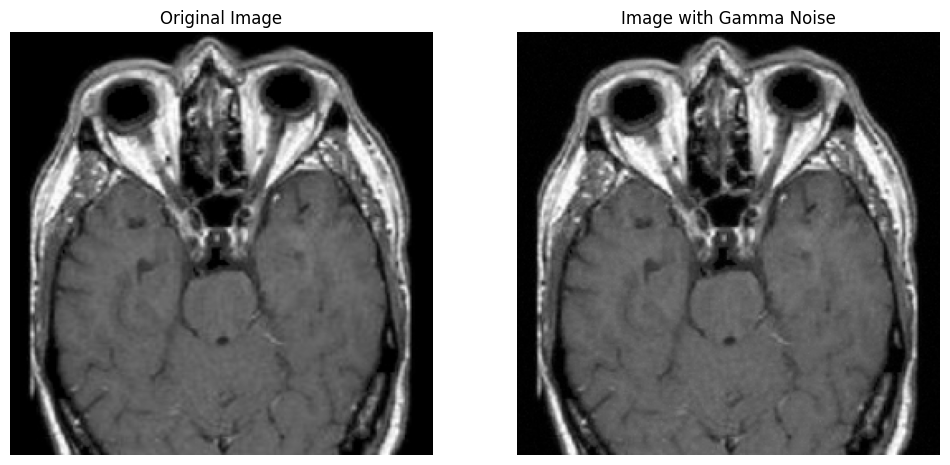

In [7]:
# Function to apply gamma noise to an image
def apply_gamma_noise(image, shape, scale):
    # Generate gamma-distributed noise
    gamma_noise = np.random.gamma(shape, scale, image.shape[:2])
    
    # Add the noise to the image
    noisy_image = np.clip(image + gamma_noise[:, :, np.newaxis], 0, 255).astype(np.uint8)
    
    return noisy_image

# Load an image
image_path = '/kaggle/input/brain-tumors-256x256/Data/normal/N_1.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if image is None:
    print("Error: Image could not be read. Make sure the path is correct.")
else:
    # Convert color from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Parameters for the gamma distribution
    shape = 2.0  # Shape parameter (k)
    scale = 1.0  # Scale parameter (theta)

    # Apply gamma noise
    noisy_image = apply_gamma_noise(image_rgb, shape, scale)

    # Plotting original and noisy images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(noisy_image)
    plt.title('Image with Gamma Noise')
    plt.axis('off')

    plt.show()

In [8]:
input_directory = '/kaggle/input/brain-tumors-256x256/Data/normal'

# Path to the directory where enhanced images will be saved
output_directory = 'normal_gamma'
os.makedirs(output_directory, exist_ok=True)

# List all files in the input directory
image_files = [f for f in os.listdir(input_directory) if os.path.isfile(os.path.join(input_directory, f))]

# Process each image
for filename in image_files:
    # Load the image
    image_path = os.path.join(input_directory, filename)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if image is not None:
        # Apply histogram equalization
        enhanced_image = apply_gamma_noise(image,  shape, scale)

        # Save the enhanced image to the output directory
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, enhanced_image)

print("Enhanced images saved to:", output_directory)

Enhanced images saved to: normal_gamma


## Removing Gamma Noise

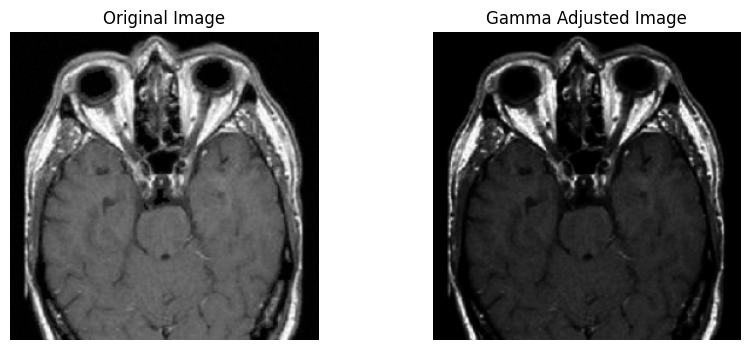

In [9]:
def adjust_gamma(image, gamma=1.0):
    # Build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(256)]).astype("uint8")
    
    return cv2.LUT(image, table)

# Load an image
image = noisy_image
if image is None:
    print("Error: Image could not be read. Make sure the path is correct.")
    exit()

# Convert image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Specify gamma value; try different values to see the effect
gamma = 0.5  # Less than 1 - Brighten; greater than 1 - Darken

# Apply gamma correction
adjusted = adjust_gamma(image, gamma=gamma)

# Set up the plot with subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the original image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')  # Turn off axis numbers and ticks

# Plot the gamma adjusted image
ax[1].imshow(adjusted)
ax[1].set_title('Gamma Adjusted Image')
ax[1].axis('off')  # Turn off axis numbers and ticks

# Display the plots
plt.show()

In [10]:
input_directory = '/kaggle/working/normal_gamma'

# Path to the directory where enhanced images will be saved
output_directory = 'Data/normal_corrected_gamma'
os.makedirs(output_directory, exist_ok=True)

# List all files in the input directory
image_files = [f for f in os.listdir(input_directory) if os.path.isfile(os.path.join(input_directory, f))]

# Process each image
for filename in image_files:
    # Load the image
    image_path = os.path.join(input_directory, filename)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if image is not None:
        # Apply histogram equalization
        enhanced_image = adjust_gamma(image)

        # Save the enhanced image to the output directory
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, enhanced_image)

print("Enhanced images saved to:", output_directory)

Enhanced images saved to: Data/normal_corrected_gamma


## Applying Impulse Noise (Salt and Pepper)

[ WARN:0@43.500] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/hpa-single-cell-image-classification/train/002679c2-bbb6-11e8-b2ba-ac1f6b6435d0_red.png'): can't open/read file: check file path/integrity


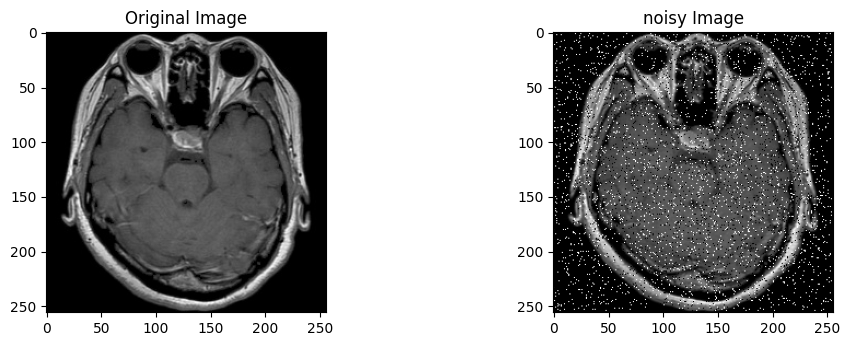

In [11]:
image = cv2.imread('/kaggle/input/hpa-single-cell-image-classification/train/002679c2-bbb6-11e8-b2ba-ac1f6b6435d0_red.png', 0)

def add_salt_and_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    noisy_image = np.copy(image)
    height, width = image.shape[:2]

    # Add salt noise
    num_salt = np.ceil(salt_prob * image.size)
    salt_coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise
    num_pepper = np.ceil(pepper_prob * image.size)
    pepper_coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

# Load an image in grayscale
image = cv2.imread('/kaggle/input/brain-tumors-256x256/Data/pituitary_tumor/P_1.jpg', 0)
# Apply contrast stretching
noisy_image = add_salt_and_pepper_noise(image)

# Display the original and stretched images
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('noisy Image')
plt.imshow(noisy_image, cmap='gray')

plt.show()

In [12]:
input_directory = '/kaggle/input/brain-tumors-256x256/Data/pituitary_tumor'

# Path to the directory where enhanced images will be saved
output_directory = 'pituitary_tumor_impulsive'
os.makedirs(output_directory, exist_ok=True)

# List all files in the input directory
image_files = [f for f in os.listdir(input_directory) if os.path.isfile(os.path.join(input_directory, f))]

# Process each image
for filename in image_files:
    # Load the image
    image_path = os.path.join(input_directory, filename)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if image is not None:
        # Apply histogram equalization
        enhanced_image = add_salt_and_pepper_noise(image)

        # Save the enhanced image to the output directory
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, enhanced_image)

print("Enhanced images saved to:", output_directory)

Enhanced images saved to: pituitary_tumor_impulsive


## Removing noise using Median filter

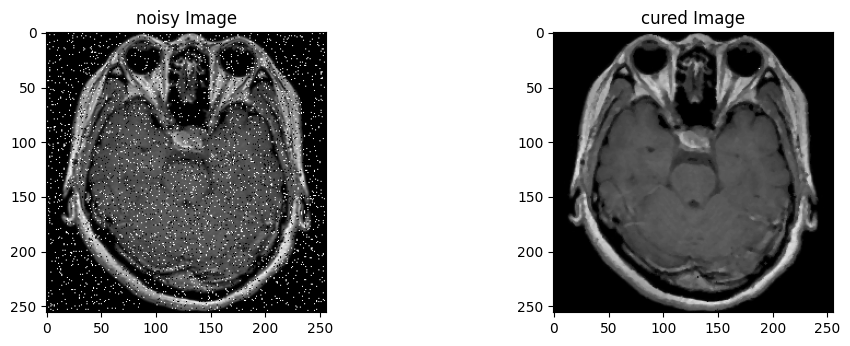

In [13]:
def median1(image):
    final = cv2.medianBlur(image, 3)
    return final

final = median1(noisy_image)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('noisy Image')
plt.imshow(noisy_image, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('cured Image')
plt.imshow(final, cmap='gray')

plt.show()

## Another implementation for median filter

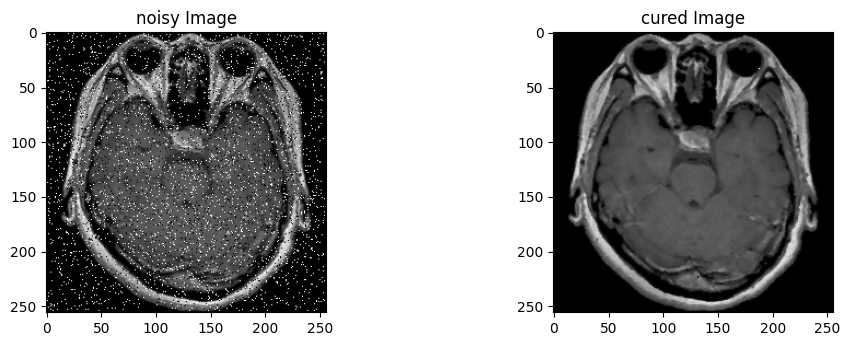

In [14]:
def median(noisy_image):
    m, n = noisy_image.shape 
    new = np.zeros([m, n]) 

    for i in range(1, m-1): 
        for j in range(1, n-1): 
            temp = [noisy_image[i-1, j-1], 
                noisy_image[i-1, j], 
                noisy_image[i-1, j + 1], 
                noisy_image[i, j-1], 
                noisy_image[i, j], 
                noisy_image[i, j + 1], 
                noisy_image[i + 1, j-1], 
                noisy_image[i + 1, j], 
                noisy_image[i + 1, j + 1]] 

            temp = sorted(temp) 
            new[i, j]= temp[4] 

    new = new.astype(np.uint8)
    return new

new = median(noisy_image)

cv2.imwrite('new_median_filtered.png', new)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title('noisy Image')
plt.imshow(noisy_image, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('cured Image')
plt.imshow(new, cmap='gray')

plt.show()

In [15]:
input_directory = '/kaggle/working/pituitary_tumor_impulsive'

# Path to the directory where enhanced images will be saved
output_directory = 'Data/pituitary_tumor_impulsive_median'
os.makedirs(output_directory, exist_ok=True)

# List all files in the input directory
image_files = [f for f in os.listdir(input_directory) if os.path.isfile(os.path.join(input_directory, f))]

# Process each image
for filename in image_files:
    # Load the image
    image_path = os.path.join(input_directory, filename)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if image is not None:
        # Apply histogram equalization
        enhanced_image = median1(image)

        # Save the enhanced image to the output directory
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, enhanced_image)

print("Enhanced images saved to:", output_directory)

Enhanced images saved to: Data/pituitary_tumor_impulsive_median


In [16]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 64
DATA_DIR = '/kaggle/working/Data'

# Use ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split 20% of data for validation
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 2479 images belonging to 4 classes.
Found 617 images belonging to 4 classes.


In [30]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler

base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Optionally, freeze the layers of the base model for initial training
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler

EPOCHS = 10
initial_lr = 0.001

# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.5
    else:
        return lr

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule, verbose=1)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3),
    lr_callback,
#     ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9387 - loss: 0.5310 - val_accuracy: 0.9254 - val_loss: 0.5138 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 978ms/step - accuracy: 0.9236 - loss: 0.4442 - val_accuracy: 0.9173 - val_loss: 0.4209 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 981ms/step - accuracy: 0.9392 - loss: 0.3672 - val_accuracy: 0.9352 - val_loss: 0.3771 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 973ms/step - accuracy: 0.9384 - loss: 0.3011 - val_accuracy: 0.9271 - val_loss: 0.3677 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001000000047

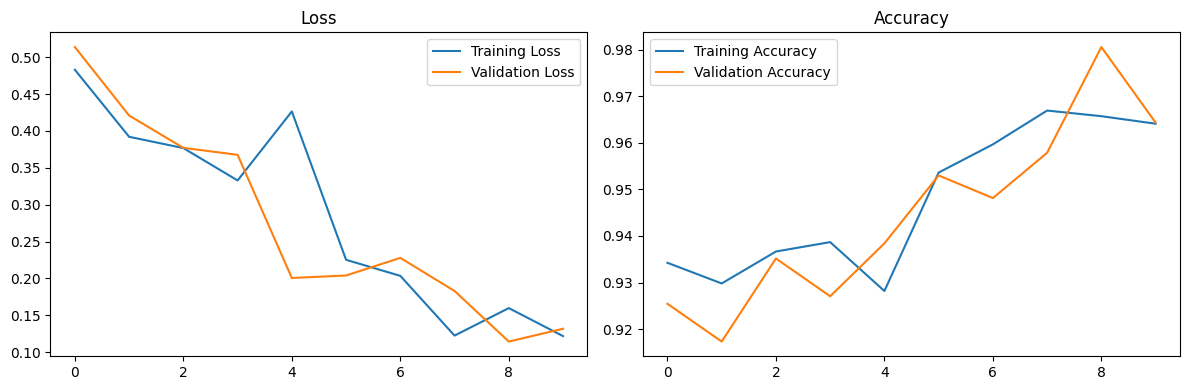

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

W0000 00:00:1715640960.146760     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step 


W0000 00:00:1715640974.714734     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[[1.0000000e+00 6.6677478e-14 3.9056767e-14 1.9342148e-24]
 [6.2857842e-01 3.7137252e-01 4.9098293e-05 5.1710514e-11]
 [1.4801197e-04 9.7708923e-01 2.2762626e-02 1.1116746e-07]
 [1.0000000e+00 1.2732073e-11 1.0330842e-19 4.9142891e-24]
 [3.7901950e-15 9.9974924e-01 2.5074984e-04 1.6605088e-13]]


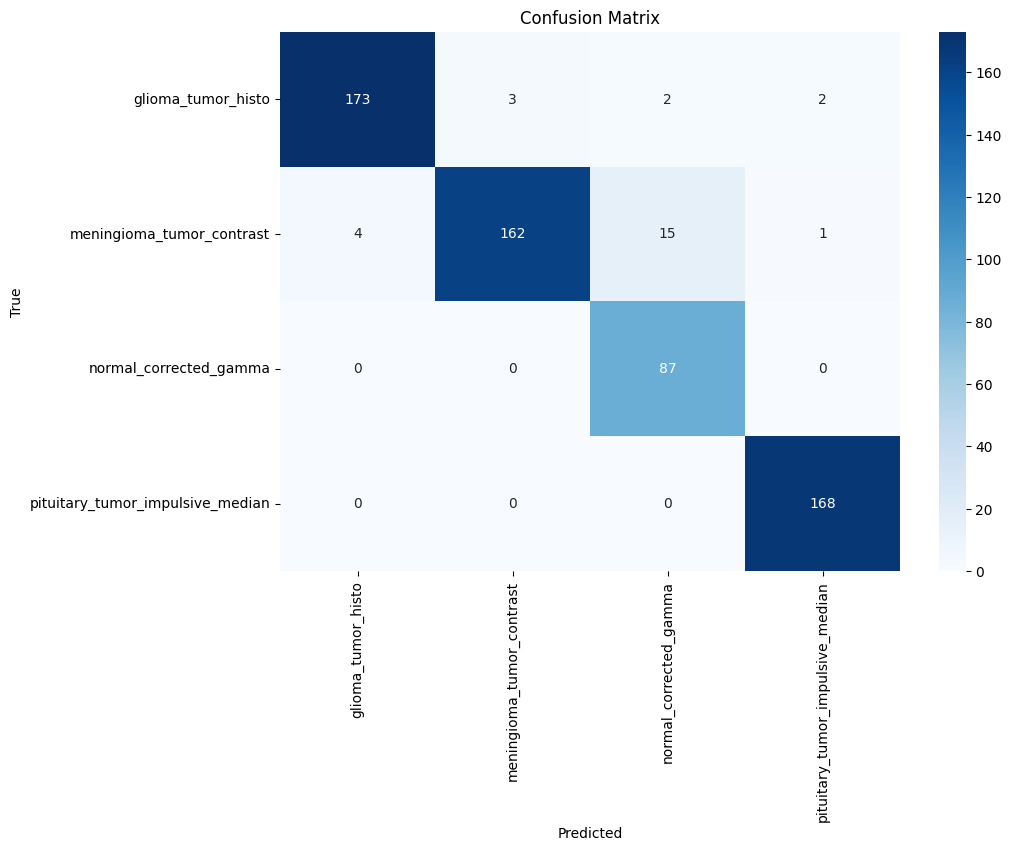

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtain the true labels from the validation generator
true_labels = val_gen.classes[val_gen.index_array]

# Predict the classes using the model
predictions = model.predict(val_gen, steps=val_gen.n // val_gen.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
print(predictions[:5])

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=val_gen.class_indices, 
            yticklabels=val_gen.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()